In [1]:
%run ../src/utils/helpers.py

import boto3
import requests
import random
import numpy as np
import tempfile
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
s3 = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)
files = [file.key for file in bucket.objects.filter()]
len(files)

134831

In [3]:
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record
    
def label_imgs(n=4):
    record = get_record()
    inp = 1
    while inp != 'q':
        # Clean slate
        clear_output()
#         for k, v in record.items():
#             print(k)
        scores = sum(v['score'] for k, v in record.items())
        print(f"{scores} great photos out of {len(record.keys())} photos scored")
        unchecked = reduce(lambda x, y: x + 1 if y['score'] == 0 and y['matches'] == 1 else x, record.values(), 0)
        print(f"{unchecked} unchecked images to go")
        # Get list of n never-before-seen images
        n_files = []
        while len(n_files) < n:
            f = random.choice(files)
            if record.get(f, {'score': None})['score'] == 0 and record.get(f, {'matches': 0})['matches'] < 2:
                n_files.append(f)
#             if f not in record:
#                 n_files.append(f)
        
        print("\nDisplaying:")
        print(n_files)
        fig = plt.figure(figsize=(35,14))
        for i, file in enumerate(n_files):
            obj = bucket.Object(file)
            tmp = tempfile.NamedTemporaryFile()
            with open(tmp.name, 'wb') as f:
                obj.download_fileobj(f)
                img=mpimg.imread(tmp.name)
            ax = fig.add_subplot(n, 1, i + 1) 
            ax.imshow(img)
            ax.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
        # Get scores
        inp = input()
        for i, image in enumerate(n_files):
            print(image, record[image])
            record[image]['score'] = record[image].get('score', 0) + (str(i + 1) in inp)
            record[image]['matches'] = record[image].get('matches', 0) + 1
        save_to(record, record_path)
        
    save_to(record, '../data/raw/record_backup.pkl')
    return record

In [ ]:
record = label_imgs(4)


Displaying images scored :
['2018/01/14/2018_0114_145000/thumbnail.jpg', '2016/09/19/2016_0919_092000/thumbnail.jpg', '2018/04/13/2018_0413_163000/thumbnail.jpg', '2016/09/23/2016_0923_084000/thumbnail.jpg', '2019/04/10/2019_0410_090000/thumbnail.jpg']


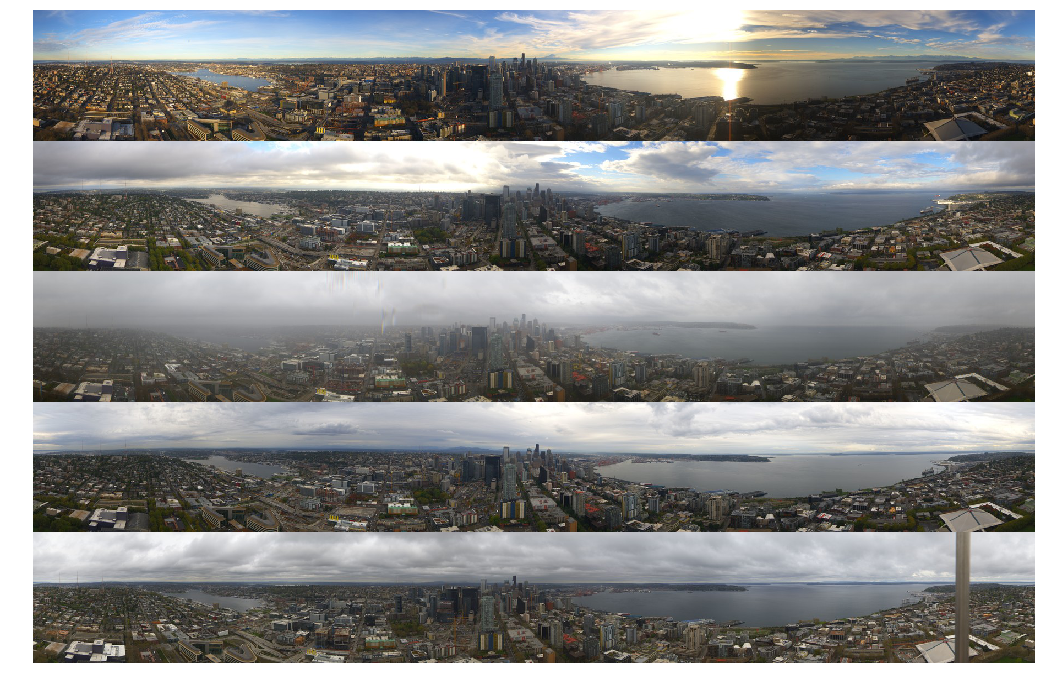

In [4]:
def review_scores(n, score=''):
    record = get_record()
    l = list(record.keys())

    # Get list of n images
    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if score:
            if record[f]['score'] == score:
                n_files.append(f)
        else:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return
review_scores(5)

In [63]:
record['2019/02/10/2019_0210_083000/thumbnail.jpg']

{'score': 1, 'matches': 1}

In [98]:
record['2019/05/23/2019_0523_191000/thumbnail.jpg']['score'] = 1

In [100]:
record_path = '../data/raw/record.pkl'
save_to(record, record_path)
save_to(record, '../data/raw/record_backup.pkl')

Saved file to ../data/raw/record.pkl
Saved file to ../data/raw/record_backup.pkl


In [52]:
def rescore(img_path, new_score=-1, new_match=-1):
    record = get_record()
    display(record[img_path])
    if new_score > -1:
        record[img_path]['score'] = new_score
    if new_match > -1:
        record[img_path]['matches'] = new_match
    display(record[img_path])
    save_to(record, '../data/raw/record.pkl')
    return
        

In [55]:
for img in list(df[df['score'] > 1].index):
#     print(img)
    rescore(img, 1, 2)

{'score': 1, 'matches': 2}

{'score': 1, 'matches': 2}

Saved file to ../data/raw/record.pkl


{'score': 1, 'matches': 2}

{'score': 1, 'matches': 2}

Saved file to ../data/raw/record.pkl


# Helpers

In [6]:
from functools import reduce

In [7]:
scores = sum(v['score'] for k, v in record.items())
print(f"{scores} great photos out of {len(record.keys())} photos scored")

1267 great photos out of 3216 photos scored


In [12]:
reduce(lambda x, y: x + 1 if y['score'] == 0 and y['matches'] == 1 else x, record.values(), 0)

906

In [ ]:
import pandas as pd

In [56]:
df = pd.DataFrame.from_dict(record, orient='index')
df[(df['score']==0) & (df['matches']==1)].shape

(0, 2)

In [53]:
record = get_record()

In [57]:
df[df['score'] > 1]

Empty DataFrame
Columns: [score, matches]
Index: []

In [51]:
for img in list(df[df['score'] > 1].index):
#     print(img)
    rescore(img, 1, 2)

2015/08/20/2015_0820_145000/thumbnail.jpg
2017/07/24/2017_0724_124000/thumbnail.jpg


In [5]:
def display_images(imgs):
    """given list of paths to images (on s3), display images"""
    n = len(imgs)
    fig = plt.figure(figsize=(35, n * 3))
    for i, file in enumerate(imgs):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig

In [96]:
def export_images(imgs):
    s3_resource = boto3.resource('s3')
    bucket = 'eye-of-the-needle'
    for file in imgs:
        fn = file.split('/')[-2]
        path = f'../reports/figures/{fn}.jpg'
        s3_resource.meta.client.download_file(bucket, file, path)
    return

In [97]:
export_images(imgs)

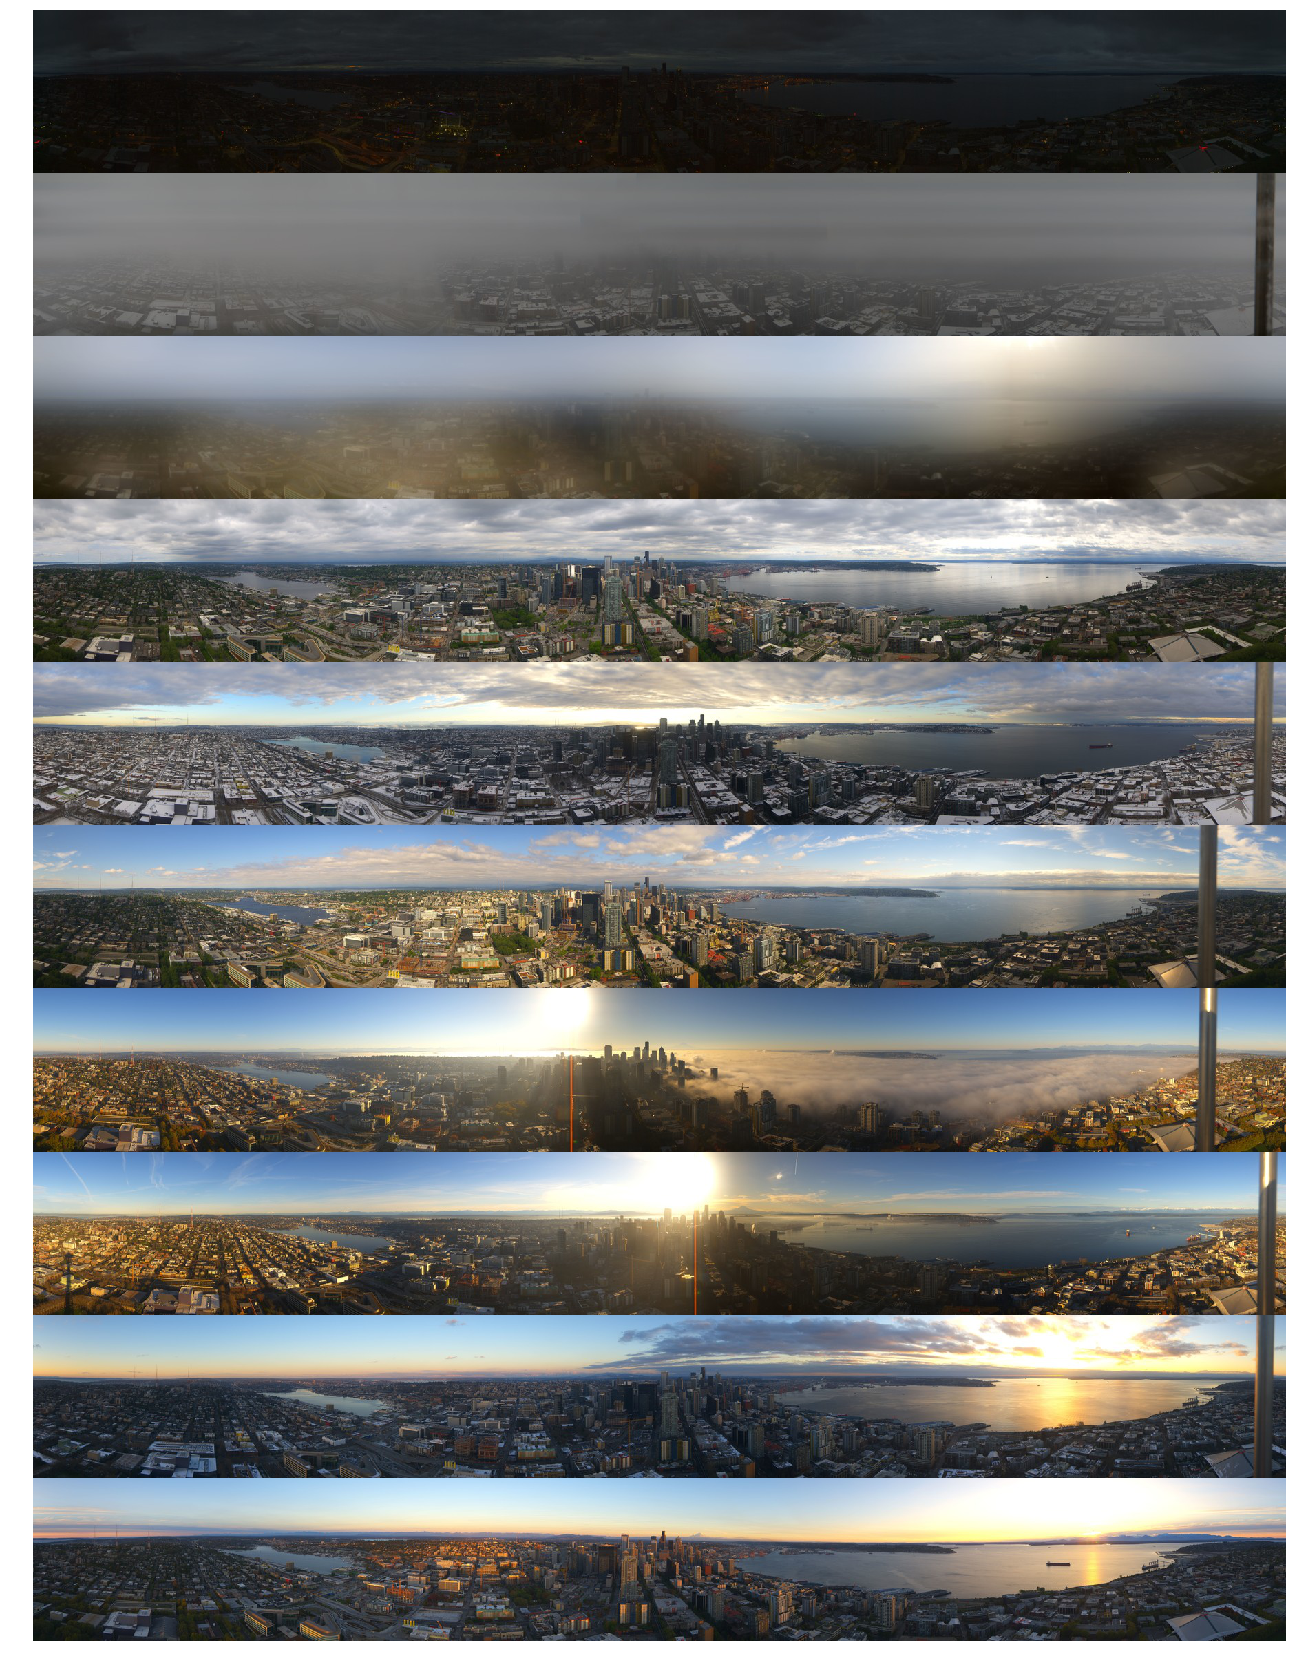

In [12]:
imgs = [
    '2017/06/14/2017_0614_045000/thumbnail.jpg',
    '2019/02/11/2019_0211_161000/thumbnail.jpg',
    '2018/04/19/2018_0419_164000/thumbnail.jpg', 
    '2018/05/17/2018_0517_163000/thumbnail.jpg', 
    '2019/02/10/2019_0210_083000/thumbnail.jpg', 
    '2018/06/21/2018_0621_165000/thumbnail.jpg',
    '2018/10/17/2018_1017_090000/thumbnail.jpg',
    '2019/01/12/2019_0112_092000/thumbnail.jpg',
    '2019/02/05/2019_0205_170000/thumbnail.jpg',
    '2016/09/27/2016_0927_184000/thumbnail.jpg'
]
img = display_images(imgs)
img.savefig('../reports/figures/panos.jpg')